In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import easyocr
import fitz  # PyMuPDF
import re
from PIL import Image
from image_cropping import crop_and_save_shooting_side_and_map_from_folder, crop_and_save_avg_formation_from_folder
from generate_graph import process_folder_with_fixed_pixel_grid, scale_mask, plot_heatmap, extract_xg_value, extract_attempts, extract_stats_from_image, process_folder_attack_side, plot_attack_side, extract_image_data,process_table_data, avg_formation_from_folder, plot_avg_formation 
from helper import find_team_folder, remove_pdfs_with_northwestern
from generate_prompt import get_team_data, generate_prompt
from player_recommend import calculate_weighted_scores, get_most_played_position, get_opponent, plot_pitch_from_dataframe

In [ ]:
team_name = "Penn State"
other_team_name = "Penn State Nittany Lion"
team_data_path = "../team-data/big-ten-combined-data.csv"
match_reports_path = "../match-reports"
logo_path = "../main_logo.png"

play_year = 2024
player_data_path = "../../player-data/player-combined-data.csv"

In [13]:
try:
    folder_path = find_team_folder(team_name, match_reports_path)
    if folder_path:
        remove_pdfs_with_northwestern(folder_path)
        print("Matching folder path:", folder_path)
    else:
        print("No matching folder found.")
except FileNotFoundError as e:
    print(e)  

Removed: ../../match-reports/penn-state-2024/Northwestern Wildcats - Penn State Nittany Lion 4-1.pdf
Matching folder path: ../../match-reports/penn-state-2024


In [14]:
crop_and_save_shooting_side_and_map_from_folder(folder_path, team_name)
crop_and_save_avg_formation_from_folder(folder_path, team_name)

Cropped image saved as ../../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../../match-reports/penn-state-2024/opp_team/shooting_side/shooting_side_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_2_St John's Red Storm_against_Penn Sta

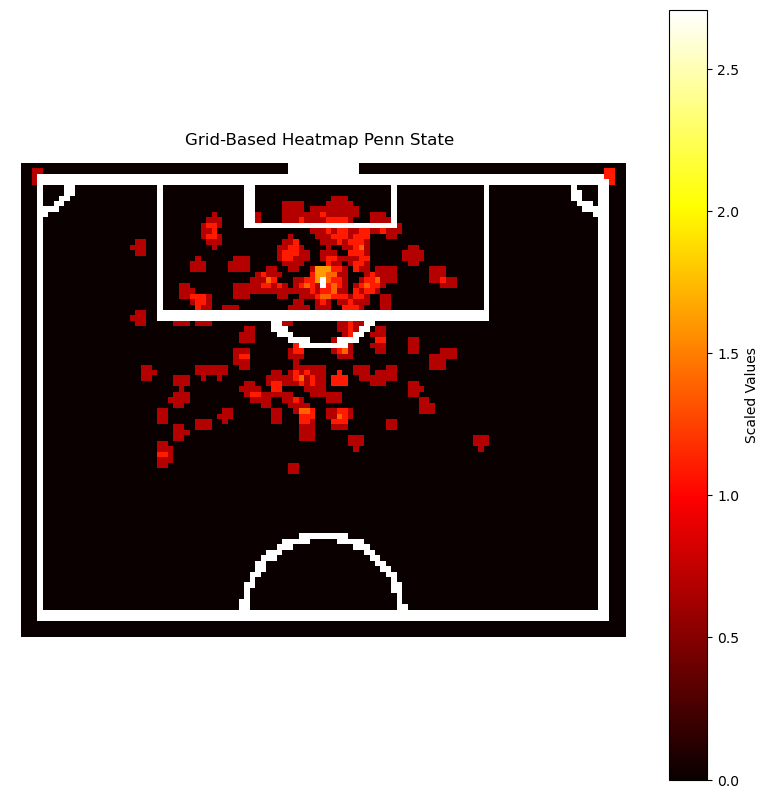

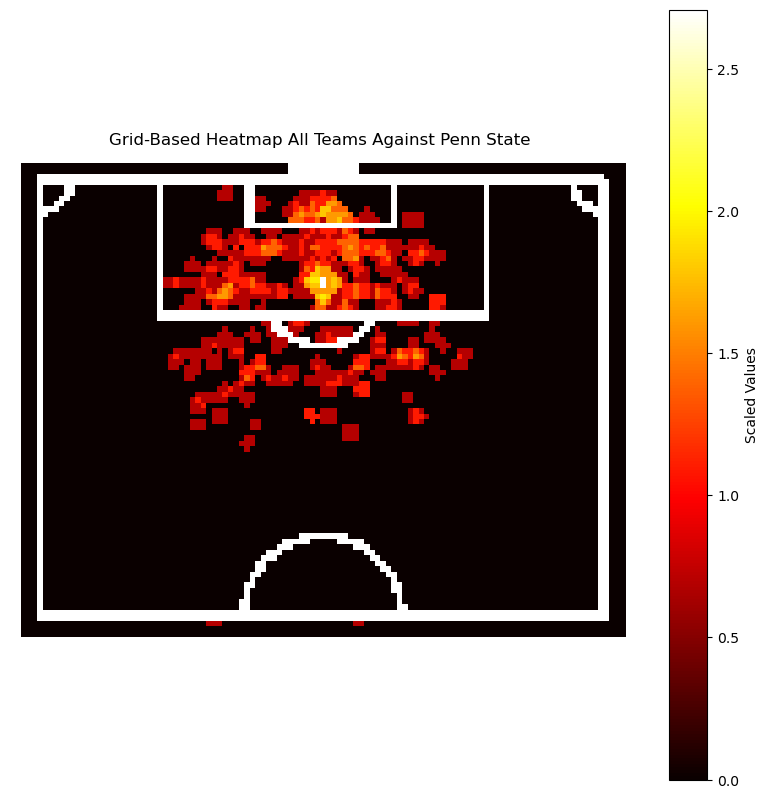

In [15]:
home_heat_map_path = os.path.join(folder_path, "home_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
home_accumulated_mask = process_folder_with_fixed_pixel_grid(home_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if home_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(home_accumulated_mask, title=f"Grid-Based Heatmap {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    
opp_heat_map_path = os.path.join(folder_path, "opp_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
opp_accumulated_mask = process_folder_with_fixed_pixel_grid(opp_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if opp_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(opp_accumulated_mask, title=f"Grid-Based Heatmap All Teams Against {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

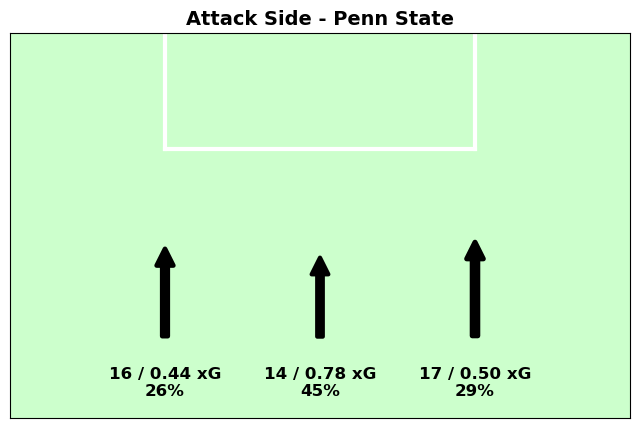

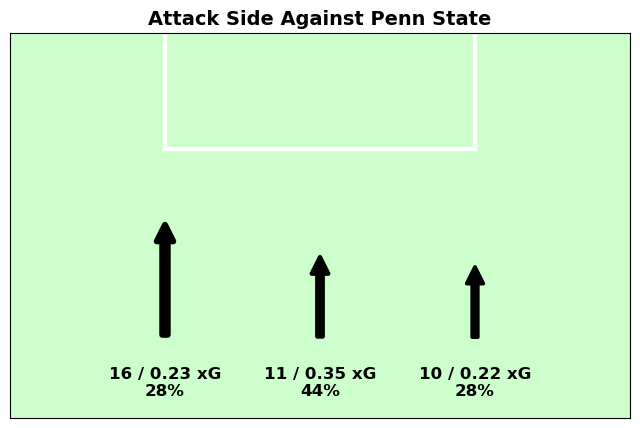

In [16]:
home_attack_side_path = os.path.join(folder_path, "home_team/shooting_side")
home_attack_side = process_folder_attack_side(home_attack_side_path)
opp_attack_side_path = os.path.join(folder_path, "opp_team/shooting_side")
opp_attack_side = process_folder_attack_side(opp_attack_side_path)
plot_attack_side(home_attack_side, title=f"Attack Side - {team_name}")
plot_attack_side(opp_attack_side, title=f"Attack Side Against {team_name}")

In [17]:
avg_formation_path = os.path.join(folder_path, "home_team/avg_formation")
avg_formation = avg_formation_from_folder(avg_formation_path, team_name)

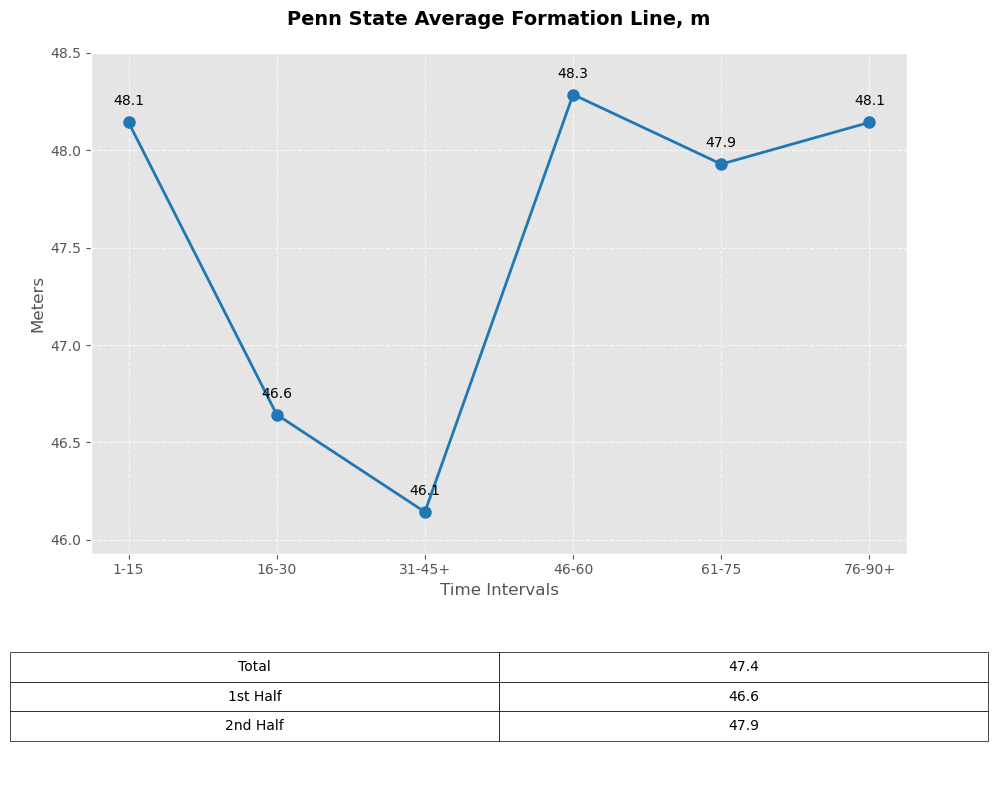

In [18]:
plot_avg_formation(avg_formation, team_name)

In [19]:
team_summary = get_team_data(team_data_path, team_name)
prompt, system_message = generate_prompt(team_summary, home_attack_side, avg_formation)

In [20]:
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
import openai
from openai import OpenAI
openai.api_key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = openai.api_key)
# Make the API call to ChatGPT
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ],
    max_tokens=200
)

# Output the analysis from ChatGPT
analysis = response.choices[0].message.content
print(analysis)

Based on the provided statistics, some of the strengths of the Penn State Nittany Lions include:

1. A good pass success rate: With a pass success rate of 77.41%, the team is adept at maintaining possession through accurate passing. This might indicate a strong midfield presence.

2. Sizable shooting stats: With 794 shots and 305 shots on target, they have a high offensive output. Their expected goal metric per shot attempt is also slightly above 1, showing that they create quality chances often.

3. Effective defense: Despite a large number of shots against (929), the team only conceded 93 goals, suggesting a solid defending line and goalkeeper.


The weaknesses of the team can be identified as:

1. Lack of ball possession: The Penn State Nittany Lions team has average ball possession standing at 49.42% and sometimes goes down to 47.35%. This implies that they might struggle to control the game and dictate the tempo, which can be


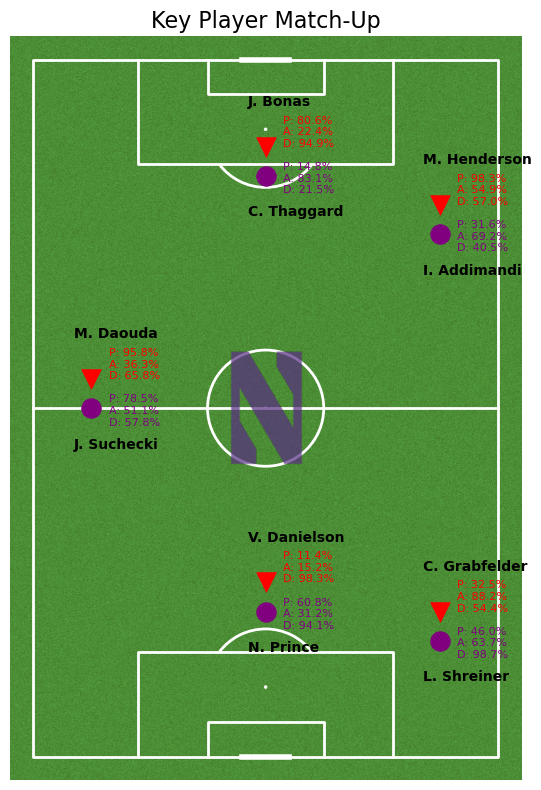

In [24]:
player_df = pd.read_csv(player_data_path)
player_df = player_df[player_df.year == play_year]

other_crucial_player = calculate_weighted_scores(player_df, other_team_name, topk=2)
nu_crucial_player = calculate_weighted_scores(player_df, "Northwestern Wildcats", topk=10)
position_data = get_most_played_position(player_df)

other_crucial_player = other_crucial_player.merge(position_data, on = ['player_name', 'team'], how = 'left')
nu_crucial_player = nu_crucial_player.merge(position_data, on = ['player_name', 'team'], how = 'left')

nu_crucial_player.drop_duplicates(inplace= True)
other_crucial_player.drop_duplicates(inplace= True)

matches_df = get_opponent(other_crucial_player, nu_crucial_player)

other_crucial_player_info = other_crucial_player[["player_name", "team", "defensive_percentile", "attacking_percentile", "passing_percentile"]]
nu_crucial_player_info = nu_crucial_player[["player_name", "team", "defensive_percentile", "attacking_percentile", "passing_percentile"]].drop_duplicates()
matches_df_with_ohio = matches_df.merge(other_crucial_player_info, left_on = ["Crucial Player Name", "Crucial Player Team"], right_on = ["player_name", "team"], how = 'left').drop(["player_name", "team"], axis = 1)
matches_df_final = matches_df_with_ohio.merge(nu_crucial_player_info, left_on = ["Opponent Player Name", "Opponent Player Team"], right_on = ["player_name", "team"], how = 'inner').drop(["player_name", "team"], axis = 1)
plot_pitch_from_dataframe(matches_df_final, logo_path)